In [17]:
# 03.1_model2_pseudo_labeling.ipynb
# Goal:
# 1) Load Montería data
# 2) Use Model-1 (teacher) + soft sensors DO/NH3 + weak prior
# 3) Blend and calibrate P(HIGH)
# 4) Generate robust labels: risk_blended (LOW/MEDIUM/HIGH)
# 5) Mark high-confidence rows, but DO NOT throw away most of the data
# 6) Export full + "trusted" CSVs for Model-3 forecasting

from pathlib import Path
import os, json, math, warnings, yaml
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8.5, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

from sklearn.metrics import classification_report, confusion_matrix
import joblib

# ---- Case-insensitive POSEIDON finder ----
def find_project_root(project_name="POSEIDON"):
    cwd = Path.cwd().resolve()
    project_name_l = project_name.lower()
    for p in [cwd] + list(cwd.parents):
        if p.name.lower() == project_name_l:
            return p
    if cwd.name.lower() == "notebooks" and cwd.parent.exists():
        return cwd.parent
    raise FileNotFoundError(f"Could not locate project root '{project_name}'. Starting cwd: {cwd}")

ROOT = find_project_root("Poseidon")

DATA      = ROOT / "data"
RAW       = DATA / "raw"
INTERIM   = DATA / "interim"
ART       = ROOT / "artifacts"
SOFT      = ART  / "soft_sensors"
MODEL_REG = ART  / "model_registry"
REPORTS   = ROOT / "reports"
CONFIGS   = ROOT / "configs"

for d in [INTERIM, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)

# ---- Thresholds config (used for weak prior) ----
th_path = CONFIGS / "thresholds.yml"
if th_path.exists():
    with open(th_path, "r") as f:
        CFG = yaml.safe_load(f)
else:
    CFG = {}
    print("WARNING: thresholds.yml not found. Weak prior will use simple defaults.")

# ---- Load Model 1 (teacher classifier) ----
MODEL1_PATH = MODEL_REG / "model1_risk_classifier.joblib"
if not MODEL1_PATH.exists():
    raise FileNotFoundError(f"Missing Model 1 at {MODEL1_PATH}. Run 02_model1_risk_classification.ipynb first.")

bundle = joblib.load(MODEL1_PATH)
teacher          = bundle["model"]
TEACHER_FEATURES = bundle["features"]
TEACHER_CLASSES  = np.array(bundle["classes"])
MODEL1_VERSION   = bundle.get("version", "model1_risk_classifier_v1")

print("Teacher features:", TEACHER_FEATURES)
print("Teacher classes:", TEACHER_CLASSES)

# ---- Load virtual sensors (soft DO & NH3) ----
vm_do_path  = SOFT / "virtual_do.joblib"
vm_nh3_path = SOFT / "virtual_nh3.joblib"
if not (vm_do_path.exists() and vm_nh3_path.exists()):
    raise FileNotFoundError("Missing soft sensors in artifacts/soft_sensors. Run 01_soft_sensors_DO_NH3.ipynb first.")

vm_do  = joblib.load(vm_do_path)   # {"model":..., "features":[temperature, pH, turbidity_proxy]}
vm_nh3 = joblib.load(vm_nh3_path)

print("Soft DO features:", vm_do["features"])
print("Soft NH3 features:", vm_nh3["features"])


ROOT: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon
Teacher features: ['temperature', 'pH', 'turbidity_proxy', 'predicted_do', 'predicted_nh3']
Teacher classes: ['HIGH' 'LOW' 'MEDIUM']
Soft DO features: ['temperature', 'pH', 'turbidity_proxy']
Soft NH3 features: ['temperature', 'pH', 'turbidity_proxy']


Cell 2 — Load Montería, canonicalize columns, build turbidity_proxy

In [18]:
# Load Montería raw data
mon_path_xlsx = DATA / "Monteria_Aquaculture_Data.xlsx"
if not mon_path_xlsx.exists():
    raise FileNotFoundError(f"Missing Montería dataset at {mon_path_xlsx}")

raw = pd.read_excel(mon_path_xlsx)

print("Raw Montería shape:", raw.shape)
display(raw.head())

# Canonicalize column names
rename = {
    "Timestamp":"timestamp", "Time":"timestamp", "time":"timestamp",
    "Temp":"temperature", "Temperature":"temperature",
    "pH":"pH", "PH":"pH",
    "Turbidity":"turbidity", "Turbidity (NTU)":"turbidity",
    "Turbidity (cm)":"turbidity_cm",
}
df = raw.rename(columns=rename).copy()

# Timestamp
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
else:
    # fallback: synthesize a timeline
    df["timestamp"] = pd.date_range("2025-01-01", periods=len(df), freq="30min")

# Basic numeric casting & clipping for temperature, pH
df["temperature"] = pd.to_numeric(df.get("temperature"), errors="coerce").clip(0, 40)
df["pH"]          = pd.to_numeric(df.get("pH"), errors="coerce").clip(5.0, 9.5)

# Turbidity proxy
if "turbidity" in df.columns:
    tb = pd.to_numeric(df["turbidity"], errors="coerce")
    # normalize to [0,1]
    eps = 1e-6
    df["turbidity_proxy"] = (tb - tb.min()) / (tb.max() - tb.min() + eps)
elif "turbidity_cm" in df.columns:
    tcm = pd.to_numeric(df["turbidity_cm"], errors="coerce")
    df["turbidity_proxy"] = 1.0 / tcm.clip(lower=1e-3)
    # normalize again
    eps = 1e-6
    tp = df["turbidity_proxy"]
    df["turbidity_proxy"] = (tp - tp.min()) / (tp.max() - tp.min() + eps)
else:
    print("WARNING: No turbidity column; using constant 0.5 as proxy.")
    df["turbidity_proxy"] = 0.5

# Sort by time
df = df.sort_values("timestamp").reset_index(drop=True)

print("After canonicalization:")
display(df[["timestamp","temperature","pH","turbidity_proxy"]].head())
print("Total Montería rows:", len(df))


Raw Montería shape: (4345, 7)


,DateTime,Temperature,Dissolved_Oxygen,pH,Turbidity,Date,Hour
0,2024-01-01 00:00:00,27.598028,6.916388,7.937212,3.677379,2024-01-01,0
1,2024-01-01 01:00:00,27.217041,6.871578,7.872365,4.110987,2024-01-01,1
2,2024-01-01 02:00:00,27.688613,5.950694,7.941378,3.039369,2024-01-01,2
3,2024-01-01 03:00:00,28.213818,6.335761,7.804893,3.611809,2024-01-01,3
4,2024-01-01 04:00:00,27.159508,6.563543,7.822742,3.885563,2024-01-01,4


After canonicalization:


,timestamp,temperature,pH,turbidity_proxy
0,2025-01-01 00:00:00,27.598028,7.937212,0.553292
1,2025-01-01 00:30:00,27.217041,7.872365,0.677565
2,2025-01-01 01:00:00,27.688613,7.941378,0.370436
3,2025-01-01 01:30:00,28.213818,7.804893,0.534500
4,2025-01-01 02:00:00,27.159508,7.822742,0.612958


Total Montería rows: 4345


Cell 3 — Compute virtual DO & NH₃, build teacher features, get proba

Teacher argmax distribution:


risk_argmax
MEDIUM    1.0
LOW       0.0
Name: proportion, dtype: float64

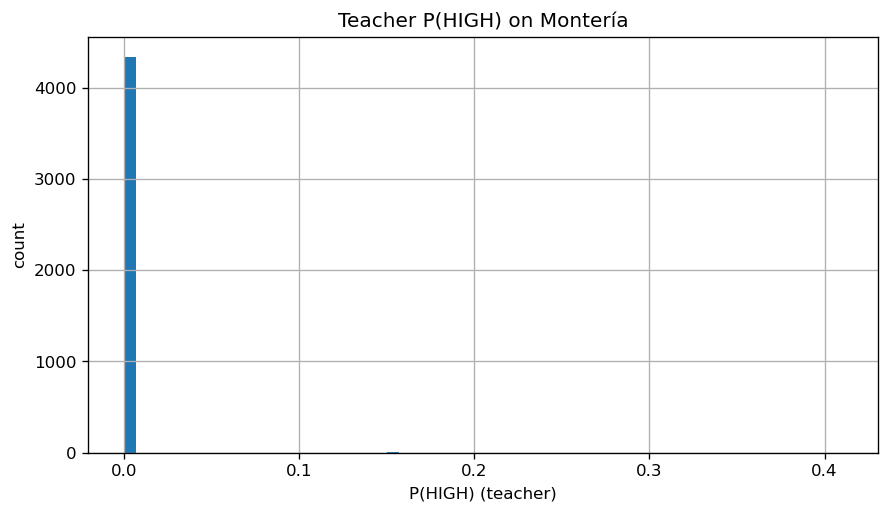

In [19]:
# Compute virtual DO and NH3 using soft sensors
X_soft = df[vm_do["features"]].astype(float).values
df["predicted_do"]  = vm_do["model"].predict(X_soft)
df["predicted_nh3"] = vm_nh3["model"].predict(X_soft)

# Teacher feature matrix
missing_teacher = [c for c in TEACHER_FEATURES if c not in df.columns]
if missing_teacher:
    raise ValueError(f"Montería missing teacher features: {missing_teacher}")

X_teacher = df[TEACHER_FEATURES].astype(float)

# Teacher probabilities
proba = teacher.predict_proba(X_teacher)
for i, c in enumerate(TEACHER_CLASSES):
    df[f"proba_{c}"] = proba[:, i]

# Teacher argmax labels
df["risk_argmax"] = TEACHER_CLASSES[np.argmax(proba, axis=1)]

# Extract teacher P(HIGH)
if "HIGH" in TEACHER_CLASSES:
    high_idx = np.where(TEACHER_CLASSES == "HIGH")[0][0]
    df["p_high_teacher"] = proba[:, high_idx]
else:
    # fallback: treat highest-prob class as "risk" (less ideal)
    df["p_high_teacher"] = proba.max(axis=1)

print("Teacher argmax distribution:")
display(df["risk_argmax"].value_counts(normalize=True).round(3))

plt.figure()
df["p_high_teacher"].hist(bins=60)
plt.title("Teacher P(HIGH) on Montería")
plt.xlabel("P(HIGH) (teacher)"); plt.ylabel("count")
plt.show()


Cell 4 — Define weak prior based on DO/NH₃/pH/turbidity/temperature

Weak prior thresholds:
DO_CRIT: 3.5 DO_LOW: 5.0
NH3_ELEV: 0.05 NH3_HIGH: 0.2
pH in [ 6.5 , 8.5 ]
TEMP_HI: 30.0
Turbidity high quantile: 0.5362717425497674
Weak prior summary:


,weak_score,weak_p_high
count,4345.000000,4345.000000
mean,2.125777,0.531444
std,0.236278,0.059069
min,0.000000,0.000000
25%,2.000000,0.500000
50%,2.000000,0.500000
75%,2.500000,0.625000
max,4.000000,1.000000


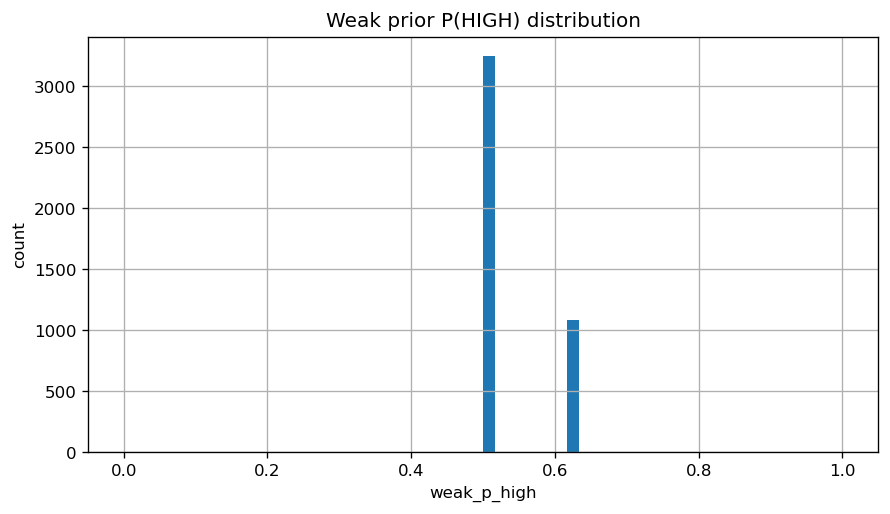

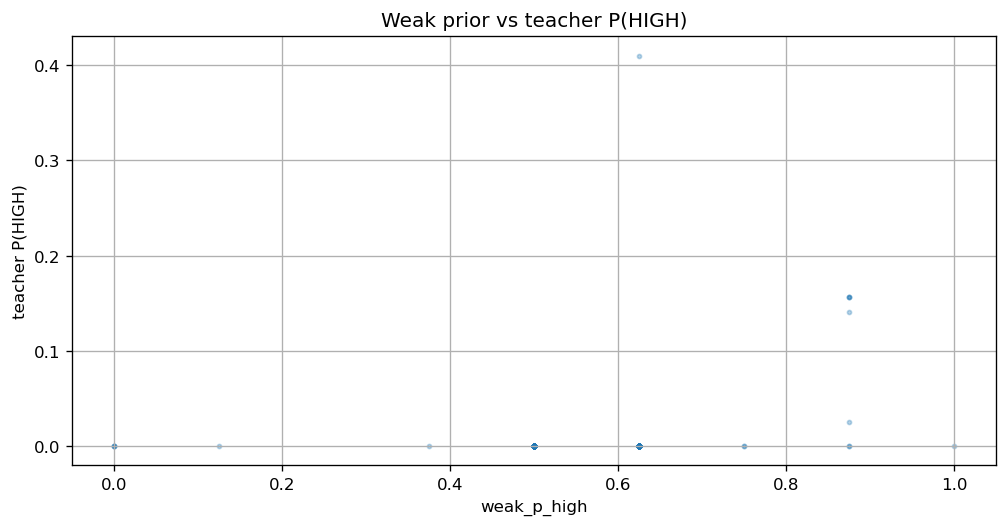

In [20]:
# Weak prior: rule-based risk signal using soft DO/NH3 + pH + turbidity_proxy + temperature

def get_cfg(path, default):
    """Safe getter: if nested config missing, return default."""
    cur = CFG
    for key in path.split("."):
        if not isinstance(cur, dict) or key not in cur:
            return default
        cur = cur[key]
    return cur

# Conservative defaults in case thresholds.yml is missing pieces
DO_CRIT   = float(get_cfg("do.primary.critical", 3.0))
DO_LOW    = float(get_cfg("do.primary.low", 4.0))
NH3_HIGH  = float(get_cfg("nh3.primary.high", 0.5))
NH3_ELEV  = float(get_cfg("nh3.primary.elevated", 0.2))
PH_LO     = float(get_cfg("pH.lo", 6.0))
PH_HI     = float(get_cfg("pH.hi", 8.5))
TEMP_HI   = float(get_cfg("temperature.hi", 30.0))
TB_Q_HIGH = float(df["turbidity_proxy"].quantile(
    float(get_cfg("turbidity_proxy.quantile_high", 0.8))
))

print("Weak prior thresholds:")
print("DO_CRIT:", DO_CRIT, "DO_LOW:", DO_LOW)
print("NH3_ELEV:", NH3_ELEV, "NH3_HIGH:", NH3_HIGH)
print("pH in [", PH_LO, ",", PH_HI, "]")
print("TEMP_HI:", TEMP_HI)
print("Turbidity high quantile:", TB_Q_HIGH)


def weak_score_row(r):
    s = 0.0
    # DO (lower = worse)
    if r["predicted_do"] < DO_CRIT:
        s += 3.0
    elif r["predicted_do"] < DO_LOW:
        s += 2.0

    # NH3 (higher = worse)
    if r["predicted_nh3"] > NH3_HIGH:
        s += 2.5
    elif r["predicted_nh3"] > NH3_ELEV:
        s += 1.5

    # pH outside comfort
    if (r["pH"] < PH_LO) or (r["pH"] > PH_HI):
        s += 1.0

    # Turbidity high
    if r["turbidity_proxy"] > TB_Q_HIGH:
        s += 0.5

    # Temperature high
    if r["temperature"] > TEMP_HI:
        s += 0.5

    return s

df["weak_score"] = df[["predicted_do","predicted_nh3","pH","turbidity_proxy","temperature"]].apply(
    weak_score_row, axis=1
)

# Normalize to [0,1]
w = df["weak_score"].values.astype(float)
df["weak_p_high"] = (w - w.min()) / (w.max() - w.min() + 1e-9)

print("Weak prior summary:")
display(df[["weak_score","weak_p_high"]].describe())

plt.figure()
df["weak_p_high"].hist(bins=60)
plt.title("Weak prior P(HIGH) distribution")
plt.xlabel("weak_p_high"); plt.ylabel("count")
plt.show()

# Scatter vs teacher
plt.figure()
plt.scatter(df["weak_p_high"], df["p_high_teacher"], s=6, alpha=0.3)
plt.xlabel("weak_p_high"); plt.ylabel("teacher P(HIGH)")
plt.title("Weak prior vs teacher P(HIGH)")
plt.tight_layout(); plt.show()


Cell 5 — Blend teacher + weak prior and calibrate prevalence

Mean teacher P(HIGH): 0.0002
Mean weak_p_high    : 0.5314
Mean blended (p_mix): 0.1862
Mean calibrated     : 0.1500 (target 0.15)


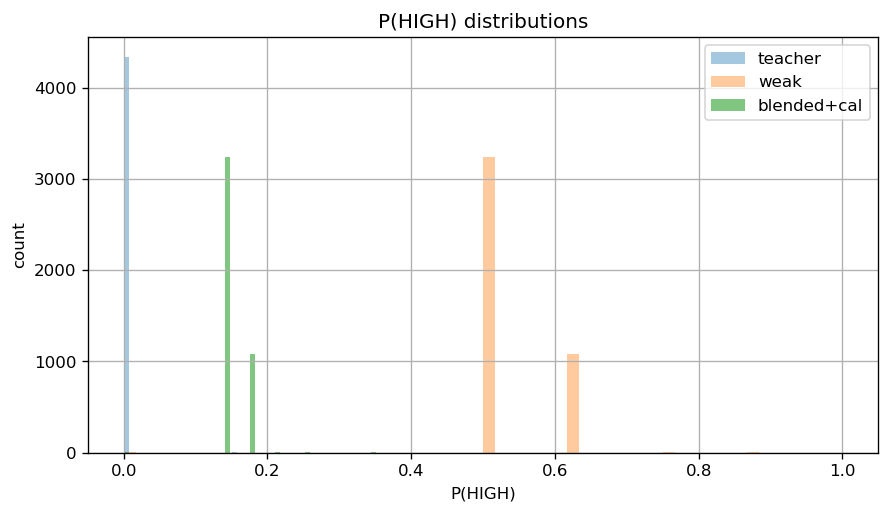

In [21]:
# Blend teacher + weak prior: p_mix = (1 - alpha)*teacher + alpha*weak
ALPHA = 0.35
p_teacher = df["p_high_teacher"].values.astype(float)
p_weak    = df["weak_p_high"].values.astype(float)

p_mix = (1 - ALPHA)*p_teacher + ALPHA*p_weak

# Target prevalence for P(HIGH): we want some non-trivial fraction (e.g., 15%)
TARGET_PREV = 0.15
eps = 1e-6
pm = np.clip(p_mix, eps, 1 - eps)
logit = np.log(pm / (1 - pm))

def mean_with_bias(B):
    z = 1.0 / (1.0 + np.exp(-(logit + B)))
    return float(z.mean())

# Bisection on bias B so mean(sigmoid(logit+B)) ~ TARGET_PREV
lo, hi = -10.0, 10.0
for _ in range(40):
    mid = 0.5 * (lo + hi)
    m = mean_with_bias(mid)
    if m < TARGET_PREV:
        lo = mid
    else:
        hi = mid
B_star = 0.5 * (lo + hi)

df["p_high_cal"] = 1.0 / (1.0 + np.exp(-(logit + B_star)))

print(f"Mean teacher P(HIGH): {p_teacher.mean():.4f}")
print(f"Mean weak_p_high    : {p_weak.mean():.4f}")
print(f"Mean blended (p_mix): {p_mix.mean():.4f}")
print(f"Mean calibrated     : {df['p_high_cal'].mean():.4f} (target {TARGET_PREV})")

plt.figure()
plt.hist(p_teacher, bins=60, alpha=0.4, label="teacher")
plt.hist(p_weak,    bins=60, alpha=0.4, label="weak")
plt.hist(df["p_high_cal"], bins=60, alpha=0.6, label="blended+cal")
plt.legend()
plt.title("P(HIGH) distributions")
plt.xlabel("P(HIGH)"); plt.ylabel("count")
plt.show()


Cell 6 — Convert calibrated P(HIGH) → LOW / MEDIUM / HIGH labels

Blended label distribution:


,count
risk_blended,
LOW,4340
MEDIUM,5


Blended label distribution (fraction):


,fraction
risk_blended,
LOW,0.999
MEDIUM,0.001


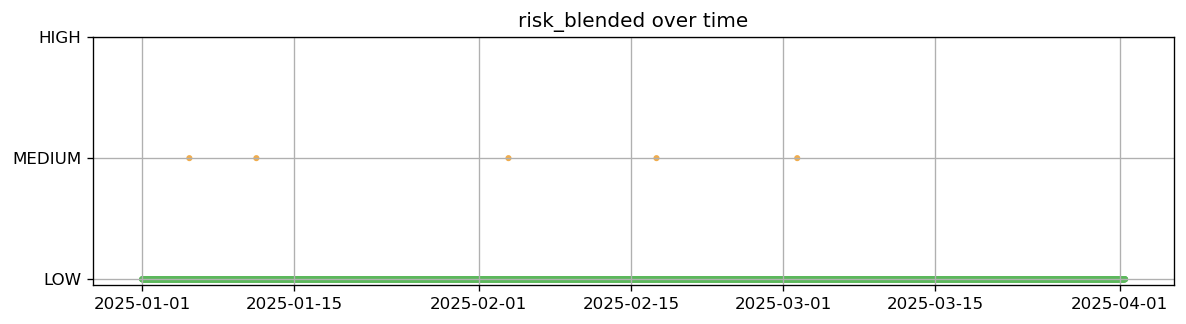

In [22]:
# Thresholds for discrete LOW/MEDIUM/HIGH
THR_HIGH = 0.65   # P(HIGH) >= 0.65 → HIGH
THR_MED  = 0.30   # 0.30 <= P(HIGH) < 0.65 → MEDIUM
# else LOW

p = df["p_high_cal"].values.astype(float)

labels = np.where(p >= THR_HIGH, "HIGH",
          np.where(p >= THR_MED, "MEDIUM", "LOW"))

df["risk_blended"] = labels

print("Blended label distribution:")
display(df["risk_blended"].value_counts().to_frame("count"))
print("Blended label distribution (fraction):")
display(df["risk_blended"].value_counts(normalize=True).round(3).to_frame("fraction"))

# Timeline plot
order = ["LOW","MEDIUM","HIGH"]
ymap = {"LOW":0, "MEDIUM":1, "HIGH":2}
plt.figure(figsize=(10,2.8))
plt.scatter(df["timestamp"], [ymap[x] for x in labels], s=7,
            c=pd.Series(labels).map({"LOW":"#5cb85c","MEDIUM":"#f0ad4e","HIGH":"#d9534f"}))
plt.yticks([0,1,2], order)
plt.title("risk_blended over time")
plt.tight_layout(); plt.show()


Cell 7 — Define a high_confidence flag (for analysis, not filtering)

We will not drop most rows. We will only mark “high_confidence” rows so you can inspect them; but trusted dataset will include all rows, because for forecasting the student can tolerate some label noise.

Confidence score summary:


count    4345.000000
mean        0.850091
std         0.017859
min         0.675237
25%         0.822472
50%         0.859461
75%         0.859461
max         0.999999
Name: conf_score, dtype: float64

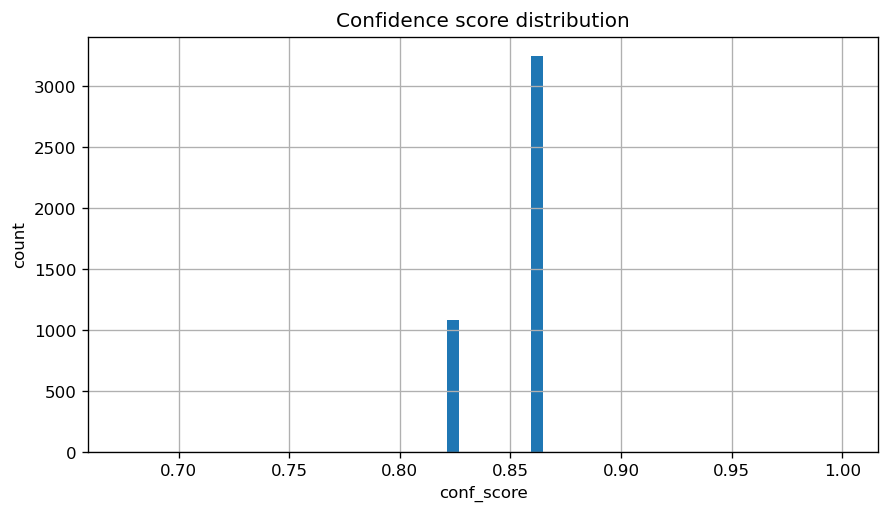

high_confidence fraction: 0.748216340621404
high_confidence counts by class:


,count
risk_blended,
LOW,3251


In [23]:
# High-confidence flag (FOR ANALYSIS ONLY, NOT FILTERING EVERYTHING OUT)

def confidence_score(row):
    p = float(row["p_high_cal"])
    lab = row["risk_blended"]
    if lab == "HIGH":
        return p              # the higher, the more confident
    elif lab == "LOW":
        return 1.0 - p        # the lower P(HIGH), the more confident LOW
    else:  # MEDIUM
        # confidence highest near the middle; use distance to 0.5
        return 1.0 - abs(p - 0.5) * 2.0  # approx in [0,1]

df["conf_score"] = df.apply(confidence_score, axis=1)

print("Confidence score summary:")
display(df["conf_score"].describe())

plt.figure()
df["conf_score"].hist(bins=60)
plt.title("Confidence score distribution")
plt.xlabel("conf_score"); plt.ylabel("count")
plt.show()

# Mark a high_confidence subset for inspection (e.g. top 50% by conf_score)
threshold_conf = df["conf_score"].quantile(0.5)
df["high_confidence"] = df["conf_score"] >= threshold_conf

print("high_confidence fraction:", df["high_confidence"].mean())
print("high_confidence counts by class:")
display(df.loc[df["high_confidence"], "risk_blended"].value_counts().to_frame("count"))


Cell 8 — Export full + “trusted” CSVs & metadata

treat ALL rows as “trusted” for forecasting, but still keep high_confidence as a column so you can analyze or filter later if needed.

In [24]:
# Columns to keep
keep_cols = [
    "timestamp",
    "temperature","pH","turbidity_proxy",
    "predicted_do","predicted_nh3",
    "p_high_teacher","weak_p_high","p_high_cal",
    "risk_argmax","risk_blended",
    "conf_score","high_confidence"
] + [c for c in df.columns if c.startswith("proba_")]

full_out = df[keep_cols].copy()

# For now: trusted = full; we are not discarding rows.
trusted_out = full_out.copy()
trusted_out["keep_for_training"] = True  # kept for compatibility with older code

print("Full pseudo-labeled shape:", full_out.shape)
print("Trusted (used by Model-3) shape:", trusted_out.shape)

p_full  = INTERIM / "monteria_pseudolabeled_full.csv"
p_trust = INTERIM / "monteria_pseudolabeled_trusted.csv"

full_out.to_csv(p_full, index=False)
trusted_out.to_csv(p_trust, index=False)

print("Saved:")
print(" -", p_full)
print(" -", p_trust)

# Metadata for debugging/reporting
meta = {
    "model1_version": MODEL1_VERSION,
    "teacher_features": TEACHER_FEATURES,
    "teacher_classes": list(map(str, TEACHER_CLASSES)),
    "alpha_blend": ALPHA,
    "target_prevalence": float(TARGET_PREV),
    "THR_HIGH": THR_HIGH,
    "THR_MED": THR_MED,
    "n_rows": int(len(df)),
    "class_counts": df["risk_blended"].value_counts().to_dict(),
    "high_confidence_fraction": float(df["high_confidence"].mean()),
}
with open(REPORTS/"pseudo_labeling_summary.json","w") as f:
    json.dump(meta, f, indent=2)

print("Saved metadata:", REPORTS/"pseudo_labeling_summary.json")


Full pseudo-labeled shape: (4345, 16)
Trusted (used by Model-3) shape: (4345, 17)
Saved:
 - C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\data\interim\monteria_pseudolabeled_full.csv
 - C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\data\interim\monteria_pseudolabeled_trusted.csv
Saved metadata: C:\Users\PC\Documents\Machine_Learning\Capstone_Project\Poseidon\reports\pseudo_labeling_summary.json


Cell 9 — Quick audit of HIGH rows

In [25]:
# Quick audit: sample HIGH rows for sanity
audit_cols = [
    "timestamp",
    "temperature","pH","turbidity_proxy",
    "predicted_do","predicted_nh3",
    "p_high_cal","risk_blended","conf_score"
]

high_sample = (df[df["risk_blended"]=="HIGH"]
               .sort_values("conf_score", ascending=False)
               [audit_cols].head(20))

print("Top 20 HIGH-risk rows by confidence:")
display(high_sample)


Top 20 HIGH-risk rows by confidence:


,timestamp,temperature,pH,turbidity_proxy,predicted_do,predicted_nh3,p_high_cal,risk_blended,conf_score
